In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
import tensorflow as tf

from cifar10 import CIFAR10

In [2]:
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
tf.set_random_seed(1)
sess = tf.InteractiveSession(config=config)

In [3]:
# Load dataset
batch_size = 64
cifar10 = CIFAR10(batch_size=batch_size, validation_proportion=0.1, augment_data=False, file='database3.csv')

SUMMARIES_DIR = './summaries/convnet'

In [4]:
# Model blocks
def conv_layer(input_tensor, kernel_shape, layer_name):
    # input_tensor b01c
    # kernel_shape 01-in-out
    weights = tf.get_variable("weights", kernel_shape,
                               initializer = tf.contrib.layers.xavier_initializer_conv2d())
    biases = tf.get_variable("biases", [kernel_shape[3]],
                             initializer=tf.constant_initializer(0.05))
    
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    
    # Other options are to use He et. al init. for weights and 0.01 
    # to init. biases.
    conv = tf.nn.conv2d(input_tensor, weights, 
                       strides = [1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

def fc_layer(input_tensor, weights_shape, layer_name):
    # weights_shape in-out
    weights = tf.get_variable("weights", weights_shape,
                              initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("biases", [weights_shape[1]],
                             initializer=tf.constant_initializer(0.0))
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    mult_out = tf.matmul(input_tensor, weights)
    return tf.nn.relu(mult_out+biases)
    

In [5]:
# Model
model_input = tf.placeholder(tf.float32, name='model_input', 
                             shape=(batch_size,1,200,1))
tf.summary.image('input', model_input, 10)

keep_prob = tf.placeholder(tf.float32, name='dropout_prob', shape=())

target = tf.placeholder(tf.float32, name='target', shape=(batch_size, 9))

# First convolution layer
layer_name = 'conv1'
with tf.variable_scope(layer_name):
    conv1_out = conv_layer(model_input, [1, 3, 1, 20], layer_name)
# First pooling layer
with tf.name_scope('pool1'):
    pool1_out = tf.nn.avg_pool(conv1_out, ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1], padding='SAME',
                name='pool1')
    

# Second convolution layer
layer_name = 'conv2'
with tf.variable_scope(layer_name):
    conv2_out = conv_layer(pool1_out, [1, 3, 20, 20], layer_name)
# Second pooling layer
with tf.name_scope('pool2'):
    pool2_out = tf.nn.avg_pool(conv2_out, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME',
                            name='pool2')



In [6]:
_,_,dim3,dim4 = pool2_out.shape

In [7]:
pool2_out_flat = tf.reshape(pool2_out, [-1, 1*dim3.value*dim4.value], name='pool2_flat')
# First fully connected layer
layer_name = 'fc1'
with tf.variable_scope(layer_name):
    fc1_out = fc_layer(pool2_out_flat, [1*dim3.value*dim4.value, 500], layer_name)
fc1_out_drop = tf.nn.dropout(fc1_out, keep_prob)

# Second fully connected layer
layer_name = 'fc2'
with tf.variable_scope(layer_name):
    fc2_out = fc_layer(fc1_out_drop, [500, 250], layer_name)
fc2_out_drop = tf.nn.dropout(fc2_out, keep_prob)


# Third fully connected layer
layer_name = 'fc3'
with tf.variable_scope(layer_name):
    fc3_out = fc_layer(fc2_out_drop, [250,9], layer_name)
model_output = fc3_out


with tf.name_scope('loss_function'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=model_output, labels=target,
                                           name='cross_entropy'))
    tf.summary.scalar('cross_entropy', cross_entropy)

In [8]:
# Optimization
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer()
    grads_vars = optimizer.compute_gradients(cross_entropy)
    optimizer.apply_gradients(grads_vars)
    train_step = optimizer.minimize(cross_entropy)

# Metrics
correct_prediction = tf.equal(tf.argmax(model_output, 1),
                             tf.argmax(target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
tf.summary.scalar('accuracy', accuracy)

# Useful training functions
def validate():
    batches = cifar10.getValidationSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    summary = sess.run(merged,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
    return summary, mean_acc
def test():
    batches = cifar10.getTestSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    return mean_acc

In [9]:
# Train model
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/train',
                                     sess.graph)
validation_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/validation')
sess.run(tf.global_variables_initializer())
cifar10.reset()
print("Trainable variables")
for n in tf.trainable_variables():
    print(n.name)

epochs = 1000
mean_gradients = np.zeros([len(tf.trainable_variables()), epochs])
std_gradients = np.zeros([len(tf.trainable_variables()), epochs])

t_i = time.time()
n_batches = cifar10.n_batches
while cifar10.getEpoch() < epochs:
    epoch = cifar10.getEpoch()
    batch, batch_idx = cifar10.nextBatch()
    batch_data = batch[0]
    batch_labels = batch[1]
    
    # just a training iteration
    _ = sess.run(train_step,
                feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 0.5
        })
    
    step = batch_idx+epoch*n_batches
    
    # Write training summary
    if step%50==0:
        summary = sess.run(merged,
                          feed_dict={
                model_input: batch_data,
                target: batch_labels,
                keep_prob: 0.5 # set to 1.0 at inference time
            })
        train_writer.add_summary(summary, step)
        
    # gradient (by layer) statistics over last training batch & validation summary
    if batch_idx==0:
        loss, acc, grads = sess.run((cross_entropy, accuracy, grads_vars), 
                      feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 1.0
        })

        for layer in range(len(tf.trainable_variables())):
            mean_gradients[layer, epoch] = np.mean(np.abs(grads[layer][0]))
            std_gradients[layer, epoch] = np.std(np.abs(grads[layer][0]))
        print("Epoch %d, training loss %f, accuracy %f" % (epoch, loss, acc))
        
        summary, validation_accuracy = validate()
        validation_writer.add_summary(summary, step)
        print("Validation accuracy %f" % validation_accuracy)
        print("Time elapsed", (time.time()-t_i)/60.0, "minutes")
train_writer.flush()
validation_writer.flush()
test_acc = test()
print("Testing set accuracy %f" % test_acc)

Trainable variables
conv1/weights:0
conv1/biases:0
conv2/weights:0
conv2/biases:0
fc1/weights:0
fc1/biases:0
fc2/weights:0
fc2/biases:0
fc3/weights:0
fc3/biases:0
Epoch 0, training loss 1.970705, accuracy 0.343750
Validation accuracy 0.261458
Time elapsed 0.004212033748626709 minutes
Epoch 1, training loss 1.819826, accuracy 0.281250
Validation accuracy 0.313542
Time elapsed 0.055353434880574544 minutes
Epoch 2, training loss 1.795250, accuracy 0.312500
Validation accuracy 0.321875
Time elapsed 0.10714449087778727 minutes
Epoch 3, training loss 1.616641, accuracy 0.359375
Validation accuracy 0.307292
Time elapsed 0.15836447874704998 minutes
Epoch 4, training loss 1.681057, accuracy 0.359375
Validation accuracy 0.320833
Time elapsed 0.20894760688145955 minutes
Epoch 5, training loss 1.710041, accuracy 0.375000
Validation accuracy 0.322917
Time elapsed 0.26081841786702475 minutes
Epoch 6, training loss 1.424991, accuracy 0.500000
Validation accuracy 0.360417
Time elapsed 0.31192145744959

Epoch 67, training loss 1.013550, accuracy 0.531250
Validation accuracy 0.559375
Time elapsed 3.4050252000490824 minutes
Epoch 68, training loss 0.952957, accuracy 0.609375
Validation accuracy 0.565625
Time elapsed 3.4555571556091307 minutes
Epoch 69, training loss 1.220915, accuracy 0.562500
Validation accuracy 0.578125
Time elapsed 3.505774402618408 minutes
Epoch 70, training loss 0.865120, accuracy 0.671875
Validation accuracy 0.540625
Time elapsed 3.556583750247955 minutes
Epoch 71, training loss 1.020613, accuracy 0.625000
Validation accuracy 0.575000
Time elapsed 3.6069401542345685 minutes
Epoch 72, training loss 1.161188, accuracy 0.609375
Validation accuracy 0.572917
Time elapsed 3.6570643544197083 minutes
Epoch 73, training loss 1.027647, accuracy 0.656250
Validation accuracy 0.578125
Time elapsed 3.70730322599411 minutes
Epoch 74, training loss 0.941246, accuracy 0.718750
Validation accuracy 0.571875
Time elapsed 3.758647020657857 minutes
Epoch 75, training loss 1.062837, acc

Epoch 136, training loss 0.966530, accuracy 0.625000
Validation accuracy 0.597917
Time elapsed 6.872051235040029 minutes
Epoch 137, training loss 1.141822, accuracy 0.593750
Validation accuracy 0.607292
Time elapsed 6.921542962392171 minutes
Epoch 138, training loss 0.942789, accuracy 0.609375
Validation accuracy 0.610417
Time elapsed 6.971456972757975 minutes
Epoch 139, training loss 0.924792, accuracy 0.671875
Validation accuracy 0.608333
Time elapsed 7.020665673414866 minutes
Epoch 140, training loss 0.882703, accuracy 0.703125
Validation accuracy 0.607292
Time elapsed 7.07066509326299 minutes
Epoch 141, training loss 0.855965, accuracy 0.671875
Validation accuracy 0.596875
Time elapsed 7.120990264415741 minutes
Epoch 142, training loss 0.781197, accuracy 0.750000
Validation accuracy 0.614583
Time elapsed 7.170327162742614 minutes
Epoch 143, training loss 0.787539, accuracy 0.796875
Validation accuracy 0.604167
Time elapsed 7.219811010360718 minutes
Epoch 144, training loss 0.838643

Epoch 204, training loss 0.991894, accuracy 0.656250
Validation accuracy 0.617708
Time elapsed 10.241253805160522 minutes
Epoch 205, training loss 0.641296, accuracy 0.750000
Validation accuracy 0.623958
Time elapsed 10.290473059813182 minutes
Epoch 206, training loss 0.794320, accuracy 0.750000
Validation accuracy 0.608333
Time elapsed 10.340483125050863 minutes
Epoch 207, training loss 0.713504, accuracy 0.781250
Validation accuracy 0.632292
Time elapsed 10.389400891462962 minutes
Epoch 208, training loss 0.758455, accuracy 0.703125
Validation accuracy 0.615625
Time elapsed 10.439385600884755 minutes
Epoch 209, training loss 0.739783, accuracy 0.609375
Validation accuracy 0.629167
Time elapsed 10.488496931393941 minutes
Epoch 210, training loss 0.856147, accuracy 0.640625
Validation accuracy 0.603125
Time elapsed 10.53760256767273 minutes
Epoch 211, training loss 0.702388, accuracy 0.812500
Validation accuracy 0.610417
Time elapsed 10.587255104382832 minutes
Epoch 212, training loss 

Epoch 272, training loss 0.693371, accuracy 0.640625
Validation accuracy 0.623958
Time elapsed 13.617460040251414 minutes
Epoch 273, training loss 0.895759, accuracy 0.687500
Validation accuracy 0.618750
Time elapsed 13.666429217656454 minutes
Epoch 274, training loss 0.685381, accuracy 0.796875
Validation accuracy 0.622917
Time elapsed 13.715957709153493 minutes
Epoch 275, training loss 0.800070, accuracy 0.671875
Validation accuracy 0.620833
Time elapsed 13.766547302405039 minutes
Epoch 276, training loss 0.659243, accuracy 0.765625
Validation accuracy 0.626042
Time elapsed 13.816939353942871 minutes
Epoch 277, training loss 0.625268, accuracy 0.718750
Validation accuracy 0.613542
Time elapsed 13.867347013950347 minutes
Epoch 278, training loss 1.001484, accuracy 0.656250
Validation accuracy 0.630208
Time elapsed 13.917936392625172 minutes
Epoch 279, training loss 0.832249, accuracy 0.671875
Validation accuracy 0.620833
Time elapsed 13.968500065803529 minutes
Epoch 280, training loss

Epoch 340, training loss 0.702572, accuracy 0.718750
Validation accuracy 0.613542
Time elapsed 16.997223591804506 minutes
Epoch 341, training loss 0.650017, accuracy 0.765625
Validation accuracy 0.646875
Time elapsed 17.046704709529877 minutes
Epoch 342, training loss 0.762036, accuracy 0.750000
Validation accuracy 0.637500
Time elapsed 17.09780712922414 minutes
Epoch 343, training loss 0.960868, accuracy 0.625000
Validation accuracy 0.641667
Time elapsed 17.147923386096956 minutes
Epoch 344, training loss 0.785372, accuracy 0.687500
Validation accuracy 0.630208
Time elapsed 17.196757551034292 minutes
Epoch 345, training loss 0.617812, accuracy 0.687500
Validation accuracy 0.641667
Time elapsed 17.246559087435404 minutes
Epoch 346, training loss 0.810724, accuracy 0.734375
Validation accuracy 0.604167
Time elapsed 17.295958320299786 minutes
Epoch 347, training loss 0.738243, accuracy 0.750000
Validation accuracy 0.614583
Time elapsed 17.345295015970866 minutes
Epoch 348, training loss 

Epoch 408, training loss 0.637285, accuracy 0.687500
Validation accuracy 0.634375
Time elapsed 20.372365840276082 minutes
Epoch 409, training loss 0.672664, accuracy 0.734375
Validation accuracy 0.641667
Time elapsed 20.42196856737137 minutes
Epoch 410, training loss 0.864360, accuracy 0.625000
Validation accuracy 0.639583
Time elapsed 20.47173209985097 minutes
Epoch 411, training loss 0.575039, accuracy 0.796875
Validation accuracy 0.633333
Time elapsed 20.52095196247101 minutes
Epoch 412, training loss 0.567688, accuracy 0.796875
Validation accuracy 0.636458
Time elapsed 20.570641632874807 minutes
Epoch 413, training loss 0.793780, accuracy 0.718750
Validation accuracy 0.627083
Time elapsed 20.61971042950948 minutes
Epoch 414, training loss 0.722976, accuracy 0.718750
Validation accuracy 0.634375
Time elapsed 20.668291529019672 minutes
Epoch 415, training loss 0.543504, accuracy 0.796875
Validation accuracy 0.633333
Time elapsed 20.7178159793218 minutes
Epoch 416, training loss 0.455

Epoch 476, training loss 0.646199, accuracy 0.750000
Validation accuracy 0.647917
Time elapsed 23.74375734726588 minutes
Epoch 477, training loss 0.605730, accuracy 0.781250
Validation accuracy 0.642708
Time elapsed 23.793104950586955 minutes
Epoch 478, training loss 0.678126, accuracy 0.687500
Validation accuracy 0.633333
Time elapsed 23.84277361234029 minutes
Epoch 479, training loss 0.705379, accuracy 0.750000
Validation accuracy 0.663542
Time elapsed 23.894968104362487 minutes
Epoch 480, training loss 0.799610, accuracy 0.671875
Validation accuracy 0.643750
Time elapsed 23.944655859470366 minutes
Epoch 481, training loss 0.523683, accuracy 0.796875
Validation accuracy 0.635417
Time elapsed 23.994415160020193 minutes
Epoch 482, training loss 0.699352, accuracy 0.703125
Validation accuracy 0.648958
Time elapsed 24.044046958287556 minutes
Epoch 483, training loss 0.736343, accuracy 0.765625
Validation accuracy 0.621875
Time elapsed 24.09409329096476 minutes
Epoch 484, training loss 0.

Epoch 544, training loss 0.648791, accuracy 0.734375
Validation accuracy 0.641667
Time elapsed 27.111919208367667 minutes
Epoch 545, training loss 0.542592, accuracy 0.703125
Validation accuracy 0.635417
Time elapsed 27.161012025674186 minutes
Epoch 546, training loss 0.708998, accuracy 0.750000
Validation accuracy 0.626042
Time elapsed 27.21015454530716 minutes
Epoch 547, training loss 0.675350, accuracy 0.703125
Validation accuracy 0.621875
Time elapsed 27.259911704063416 minutes
Epoch 548, training loss 0.855916, accuracy 0.687500
Validation accuracy 0.635417
Time elapsed 27.309399743874867 minutes
Epoch 549, training loss 0.716964, accuracy 0.765625
Validation accuracy 0.631250
Time elapsed 27.359598155816396 minutes
Epoch 550, training loss 0.553964, accuracy 0.812500
Validation accuracy 0.626042
Time elapsed 27.410531500975292 minutes
Epoch 551, training loss 0.708678, accuracy 0.750000
Validation accuracy 0.628125
Time elapsed 27.46024219195048 minutes
Epoch 552, training loss 0

Epoch 612, training loss 0.575294, accuracy 0.781250
Validation accuracy 0.641667
Time elapsed 30.481745254993438 minutes
Epoch 613, training loss 0.645239, accuracy 0.765625
Validation accuracy 0.645833
Time elapsed 30.531984659036002 minutes
Epoch 614, training loss 0.747135, accuracy 0.734375
Validation accuracy 0.642708
Time elapsed 30.583285760879516 minutes
Epoch 615, training loss 0.637515, accuracy 0.812500
Validation accuracy 0.640625
Time elapsed 30.63259885708491 minutes
Epoch 616, training loss 0.692829, accuracy 0.734375
Validation accuracy 0.636458
Time elapsed 30.681724588076275 minutes
Epoch 617, training loss 0.608379, accuracy 0.765625
Validation accuracy 0.638542
Time elapsed 30.730995122591654 minutes
Epoch 618, training loss 0.801430, accuracy 0.718750
Validation accuracy 0.641667
Time elapsed 30.78027007977168 minutes
Epoch 619, training loss 0.570750, accuracy 0.812500
Validation accuracy 0.635417
Time elapsed 30.829673810799918 minutes
Epoch 620, training loss 0

Epoch 680, training loss 0.516374, accuracy 0.765625
Validation accuracy 0.638542
Time elapsed 33.840372057755786 minutes
Epoch 681, training loss 0.552157, accuracy 0.781250
Validation accuracy 0.632292
Time elapsed 33.889476625124615 minutes
Epoch 682, training loss 0.539798, accuracy 0.781250
Validation accuracy 0.640625
Time elapsed 33.939638066291806 minutes
Epoch 683, training loss 0.639653, accuracy 0.796875
Validation accuracy 0.631250
Time elapsed 33.98881398439407 minutes
Epoch 684, training loss 0.597012, accuracy 0.812500
Validation accuracy 0.621875
Time elapsed 34.03743483622869 minutes
Epoch 685, training loss 0.700150, accuracy 0.687500
Validation accuracy 0.617708
Time elapsed 34.08762327035268 minutes
Epoch 686, training loss 0.531892, accuracy 0.796875
Validation accuracy 0.634375
Time elapsed 34.1364803592364 minutes
Epoch 687, training loss 0.810836, accuracy 0.765625
Validation accuracy 0.636458
Time elapsed 34.18506654103597 minutes
Epoch 688, training loss 0.529

Epoch 748, training loss 0.501358, accuracy 0.843750
Validation accuracy 0.647917
Time elapsed 37.19565317233403 minutes
Epoch 749, training loss 0.676975, accuracy 0.734375
Validation accuracy 0.654167
Time elapsed 37.24522011677424 minutes
Epoch 750, training loss 0.489030, accuracy 0.765625
Validation accuracy 0.651042
Time elapsed 37.294960196812944 minutes
Epoch 751, training loss 0.736586, accuracy 0.671875
Validation accuracy 0.651042
Time elapsed 37.34397997458776 minutes
Epoch 752, training loss 0.672313, accuracy 0.687500
Validation accuracy 0.640625
Time elapsed 37.39364751577377 minutes
Epoch 753, training loss 0.763227, accuracy 0.671875
Validation accuracy 0.635417
Time elapsed 37.443670483430225 minutes
Epoch 754, training loss 0.451948, accuracy 0.859375
Validation accuracy 0.641667
Time elapsed 37.493020780881245 minutes
Epoch 755, training loss 0.643461, accuracy 0.796875
Validation accuracy 0.634375
Time elapsed 37.54226313034693 minutes
Epoch 756, training loss 0.78

Epoch 816, training loss 0.628989, accuracy 0.718750
Validation accuracy 0.650000
Time elapsed 40.56376813252767 minutes
Epoch 817, training loss 0.504075, accuracy 0.750000
Validation accuracy 0.640625
Time elapsed 40.61296551624934 minutes
Epoch 818, training loss 0.680460, accuracy 0.750000
Validation accuracy 0.641667
Time elapsed 40.661869557698566 minutes
Epoch 819, training loss 0.438723, accuracy 0.828125
Validation accuracy 0.629167
Time elapsed 40.71056580543518 minutes
Epoch 820, training loss 0.496925, accuracy 0.812500
Validation accuracy 0.635417
Time elapsed 40.76027395327886 minutes
Epoch 821, training loss 0.501751, accuracy 0.859375
Validation accuracy 0.644792
Time elapsed 40.80887798468272 minutes
Epoch 822, training loss 0.477175, accuracy 0.859375
Validation accuracy 0.641667
Time elapsed 40.85822957754135 minutes
Epoch 823, training loss 0.523522, accuracy 0.781250
Validation accuracy 0.642708
Time elapsed 40.908240822951 minutes
Epoch 824, training loss 0.488997

Epoch 884, training loss 0.505827, accuracy 0.796875
Validation accuracy 0.641667
Time elapsed 43.94823694229126 minutes
Epoch 885, training loss 0.640545, accuracy 0.765625
Validation accuracy 0.652083
Time elapsed 44.00129469633102 minutes
Epoch 886, training loss 0.694110, accuracy 0.718750
Validation accuracy 0.634375
Time elapsed 44.054522252082826 minutes
Epoch 887, training loss 0.480651, accuracy 0.781250
Validation accuracy 0.644792
Time elapsed 44.10406101942063 minutes
Epoch 888, training loss 0.614207, accuracy 0.750000
Validation accuracy 0.635417
Time elapsed 44.15331288178762 minutes
Epoch 889, training loss 0.434477, accuracy 0.843750
Validation accuracy 0.639583
Time elapsed 44.20269068479538 minutes
Epoch 890, training loss 0.464863, accuracy 0.828125
Validation accuracy 0.637500
Time elapsed 44.25235249996185 minutes
Epoch 891, training loss 0.615456, accuracy 0.765625
Validation accuracy 0.639583
Time elapsed 44.300756740570066 minutes
Epoch 892, training loss 0.729

Epoch 952, training loss 0.683863, accuracy 0.734375
Validation accuracy 0.637500
Time elapsed 47.32746798992157 minutes
Epoch 953, training loss 0.435037, accuracy 0.890625
Validation accuracy 0.628125
Time elapsed 47.37725901206334 minutes
Epoch 954, training loss 0.530536, accuracy 0.796875
Validation accuracy 0.623958
Time elapsed 47.42640407085419 minutes
Epoch 955, training loss 0.596456, accuracy 0.765625
Validation accuracy 0.637500
Time elapsed 47.47579183975856 minutes
Epoch 956, training loss 0.610215, accuracy 0.750000
Validation accuracy 0.645833
Time elapsed 47.524934128920236 minutes
Epoch 957, training loss 0.660489, accuracy 0.796875
Validation accuracy 0.645833
Time elapsed 47.57452039718628 minutes
Epoch 958, training loss 0.509664, accuracy 0.781250
Validation accuracy 0.634375
Time elapsed 47.624067930380505 minutes
Epoch 959, training loss 0.470406, accuracy 0.812500
Validation accuracy 0.640625
Time elapsed 47.673223602771756 minutes
Epoch 960, training loss 0.44

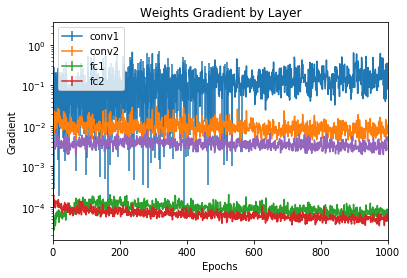

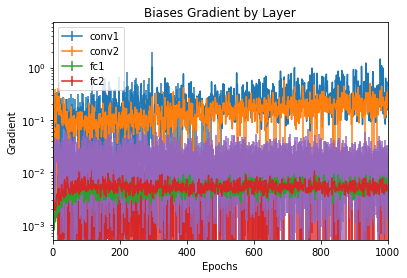

In [10]:
# Plotting gradients
n_layers = len(tf.trainable_variables()) // 2
x = np.arange(epochs)
i = 0
plt.figure()
while i < n_layers*2:
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Weights Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"][-n_layers:])
plt.xlim(-0.2, epochs)
plt.show()
i = 1
plt.figure()
while i < n_layers*2:
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Biases Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"][-n_layers:])
plt.xlim(-0.2, epochs)
plt.show()

In [11]:
def confusion_matrix(targets, outputs):
    '''Returns a confusion matrix. Both targets and outputs
    should be 1-D arrays of zeros and ones.'''
    encoded_data = 2*targets+outputs  # Map targets and outputs to {0, 1, 2, 3}
    TN = np.sum(encoded_data == 0)  # True negatives
    FP = np.sum(encoded_data == 1)  # False positives
    FN = np.sum(encoded_data == 2)  # False negatives
    TP = np.sum(encoded_data == 3)  # True positives
    return ((TP, FP), (FN, TN))

def roc_curve(targets, outputs):
    '''Returns a ROC curve. Outputs should be in range 0-1
    in order to move the threshold.'''
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        outputs_with_threshold = (outputs > threshold).astype(np.float)
        ((TP, FP), (FN, TN)) = confusion_matrix(
            targets, 
            outputs_with_threshold)
        tpr.append(TP/(TP+FN))
        fpr.append(FP/(FP+TN))
    return np.array(tpr), np.array(fpr)
accs = sess.run(accuracy,
             feed_dict={
            model_input: cifar10.training_data,
                       target: cifar10.training_labels,
            keep_prob: 1.0
        })

accs = np.asarray(accs)
[[VN,FP],[FN,VP]] = confusion_matrix(
    accs,
    (accs>0.5).astype(np.float))
print('VP: %d, VN: %d, FP: %d, FN: %d' %(VP,VN,FP,FN))
print('Porcentaje de clasificaciones correctas: %%%f' %(100.0*(VP+VN)/(VP+VN+FP+FN)))
print('Precision: %%%f' %(100.0*VP/(VP+FP)))
print('Recall: %%%f' %(100.0*VP/(VP+FN)))
print('')


AttributeError: 'CIFAR10' object has no attribute 'training_data'